# weighted conjunctive EM keys
- explicit weighing of conjunctions in EM key
    - stim_weight = 1, context_weight = 0.0005
- EM value is taken from feed forward pathway 

### NB this script analyzes two separate sweeps. 
- the only difference between them is trlen=1 or 10
- if trlen=10 i've included a flag, the code has paths to both



In [2]:
import torch as tr
import numpy as np

import itertools

from PM_models import *
from PM_tasks import *
from help_amtask import *

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [3]:
nmapsL=[4,5,6]
ntrialsL=[2]
switchL=[1,0]
wmsizeL=[4,5,6]
fdir = 'model_data/amtask_barcode_split/'

In [4]:
def load_states_subj(wmsize,nmaps,switch,ntrials,trlen=10,seed=0):
  ''' 
  selects which state (c or h)
  selects relevant timesteps (encoding,test,both)
  reshapes to uncat trial and trlen dimensions
  '''
  hc = 0 
  phase = 0 # 0:encoding,1:test,2:both
  if trlen==1:
    fpath = "wmsize_%i-nmaps_%i-switch_%i-ntrials_%i-seed_%i-wm_emkw_0.000500-states.npy"%(
              wmsize,nmaps,switch,ntrials,seed)
  elif trlen==10:
    fpath = "wmsize_%i-nmaps_%i-switch_%i-ntrials_%i-trlen_10-seed_%i-wm_emkw_0.000500-states.npy"%(
              wmsize,nmaps,switch,ntrials,seed)
  try:
    states_subj = np.load(fdir+fpath) # [neps,tsteps,hc,stsize]
  except:
    return None
  neps,tsteps,_,stsize = states_subj.shape
  # select h or c state
  states_subj = states_subj[:,:,hc]
  states_subj = states_subj.reshape(neps,ntrials,int(tsteps/ntrials),stsize)
  if phase==0: # encoding phase
    states_subj = states_subj[:,:,:nmaps]
  elif phase==1: # test phase
    states_subj = states_subj[:,:,nmaps:]
  elif phase==2: # both
    states_subj = states_subj[:]
  return states_subj

def load_trsc_subj(wmsize,nmaps,switch,ntrials,trlen=10,seed=0):
  if trlen==1:
    fpath = "wmsize_%i-nmaps_%i-switch_%i-ntrials_%i-seed_%i-wm_emkw_0.000500-trsc.npy"%(
            wmsize,nmaps,switch,ntrials,seed)
  elif trlen==10:
    fpath = "wmsize_%i-nmaps_%i-switch_%i-ntrials_%i-trlen_10-seed_%i-wm_emkw_0.000500-trsc.npy"%(
            wmsize,nmaps,switch,ntrials,seed)
  try:
    trsc_subj = np.load(fdir+fpath)
  except:
    return None
  return trsc_subj

def load_states(wmsize,nmaps,switch,ntrials,trlen=10,nnets=20):
  L = []
  for seed in range(nnets):
    states_subj = load_states_subj(wmsize,nmaps,switch,ntrials,trlen,seed)
    if type(states_subj) == type(None):
      continue
    L.append(states_subj)
  return np.array(L)

def load_trsc(wmsize,nmaps,switch,ntrials,trlen=10,nnets=20):
  L = []
  for seed in range(nnets):
    trsc_subj = load_trsc_subj(wmsize,nmaps,switch,ntrials,trlen,seed)
    if type(trsc_subj) == type(None):
      continue
    L.append(trsc_subj)
  return np.array(L)

# trac

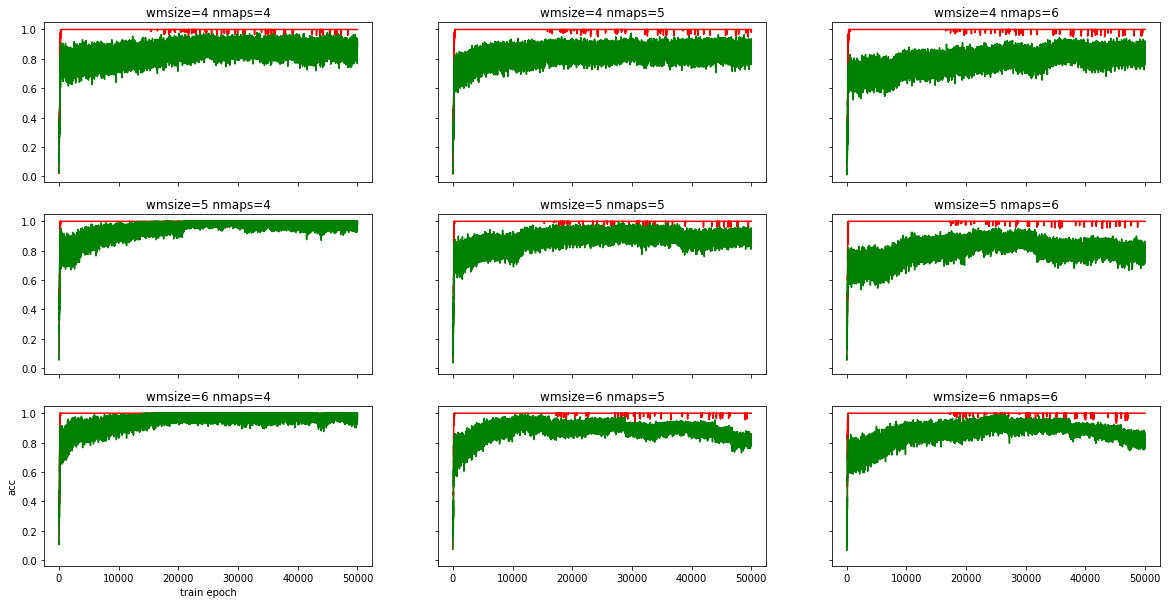

In [5]:
fig,axarr = plt.subplots(3,3,figsize=(20,10),sharex=True,sharey=True);
trlen = 10
ntrials = 2
for wmsize,nmaps in itertools.product(wmsizeL,nmapsL):
  ax = axarr[wmsize-4,nmaps-4]
  ax.set_title('wmsize=%i nmaps=%i'%(wmsize,nmaps))
  for switch in [0,1]:
    trsc = load_trsc(wmsize,nmaps,switch,ntrials,trlen,nnets=20)
    ax.plot(trsc[:,:,1,nmaps:].mean((0,-1)),c=['r','g'][switch])
axarr[2,0].set_ylabel('acc')
axarr[2,0].set_xlabel('train epoch')
plt.savefig('figures/amtask-barcode_split/tracc-trlen_%i'%trlen)

# tr1tr2 separation over training

In [6]:
def compute_separation(states_subj):
  ''' separation of tr1tr2 for each epoch
  states_subj [neps,ntrials,tsteps,stsize]
  returns tr1tr2 separation for each epoch
  '''
  neps,ntrials,tsteps,stsize = states_subj.shape
  sep_tr1tr2 = -np.ones(neps)
  # loop over epochs
  for ep in range(neps):
    states_ep = states_subj[ep]
    # select states from first two trials
    states_tr1tr2 = states_ep[(0,1),:] 
    # cat trials on tsteps, compute between trial distances
    states_tr1tr2 = states_tr1tr2.reshape(-1,stsize) 
    rdm_tr1tr2 = compute_rdm(states_tr1tr2)
    # separation as mean off block rdm
    sep_tr1tr2[ep] = rdm_tr1tr2[tsteps:,:tsteps].mean()
  return sep_tr1tr2

### group level separations

In [7]:
''' separation for each group: compute and save '''
# for wmsize,nmaps,switch,ntrials,trlen in itertools.product(wmsizeL,nmapsL,switchL,ntrialsL,[1,10]):
#   print(wmsize,nmaps,switch,ntrials,trlen)
#   states = load_states(wmsize,nmaps,switch,ntrials,trlen,20)
#   sep = -np.ones([*states.shape[:2]])
#   for idx in range(len(sep)):
#     sep[idx] = compute_separation(states[idx])
#   fname = 'wmsize_%i-nmaps_%i-switch_%i-ntrials_%i-trlen_%i'%(wmsize,nmaps,switch,ntrials,trlen)
#   np.save('model_data/amtask_barcode_split_analysis/'+'sep_'+fname,sep)

4 4 1 2 1
4 4 1 2 10
4 4 0 2 1
4 4 0 2 10
4 5 1 2 1
4 5 1 2 10
4 5 0 2 1
4 5 0 2 10
4 6 1 2 1
4 6 1 2 10
4 6 0 2 1
4 6 0 2 10
5 4 1 2 1
5 4 1 2 10
5 4 0 2 1
5 4 0 2 10
5 5 1 2 1
5 5 1 2 10
5 5 0 2 1
5 5 0 2 10
5 6 1 2 1
5 6 1 2 10
5 6 0 2 1
5 6 0 2 10
6 4 1 2 1
6 4 1 2 10
6 4 0 2 1
6 4 0 2 10
6 5 1 2 1
6 5 1 2 10
6 5 0 2 1
6 5 0 2 10
6 6 1 2 1
6 6 1 2 10
6 6 0 2 1
6 6 0 2 10


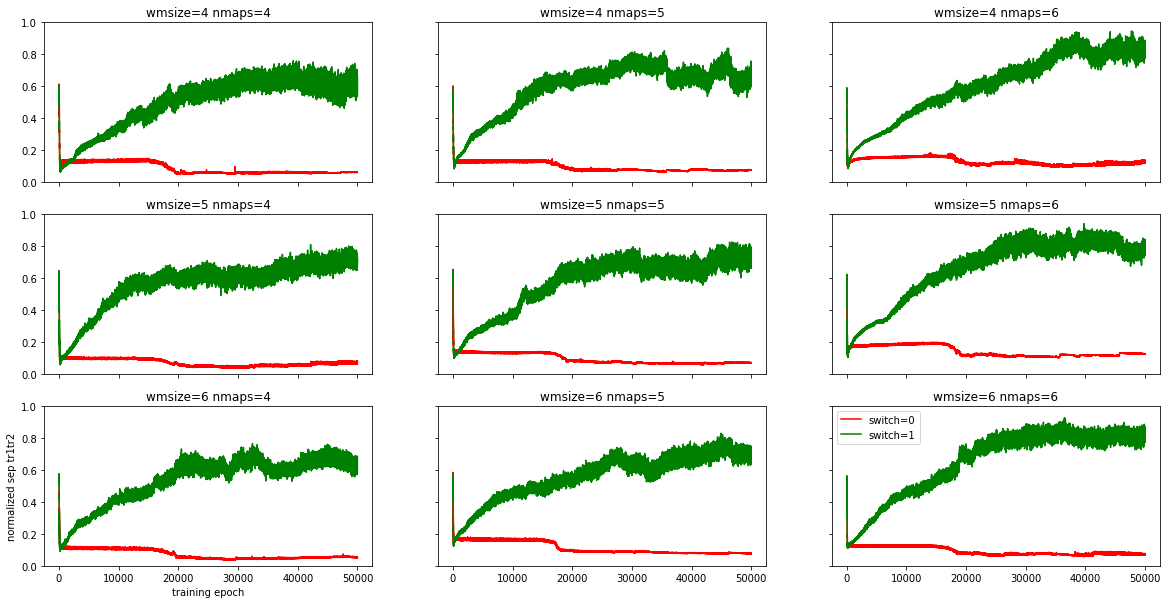

In [7]:
trlen = 10
fig,axarr = plt.subplots(3,3,figsize=(20,10),sharex=True,sharey=True);

for wmsize,nmaps in itertools.product(wmsizeL,nmapsL):
  ax = axarr[wmsize-4,nmaps-4]
  ax.set_ylim(0,1)
  ax.set_title('wmsize=%i nmaps=%i'%(wmsize,nmaps))
  for switch in [0,1]:
    outdir = 'model_data/amtask_barcode_split_analysis/'
    fname = 'wmsize_%i-nmaps_%i-switch_%i-ntrials_%i-trlen_%i'%(wmsize,nmaps,switch,ntrials,trlen)
    sep = np.load('model_data/amtask_barcode_split_analysis/'+'sep_'+fname+'.npy')
    ax.plot(sep.mean(0),label='switch=%i'%switch,c=['r','g'][switch])
ax.legend()
axarr[2,0].set_xlabel('training epoch')
axarr[2,0].set_ylabel('normalized sep tr1tr2')

plt.savefig('figures/amtask-barcode_split/sep_switch01-trlen_%i'%trlen)

## correlation between accuracy and separation

In [9]:
''' compute moving corr '''
def mov_cor(trac_subj,sep_subj,wind=100):
  ntsteps = len(trac_subj)
  rho_subj = -np.ones(ntsteps-wind)
  for idx in range(ntsteps-wind):
    idx
    rho,pval = pearsonr(trac_subj[idx:idx+wind],sep_subj[idx:idx+wind])
    rho_subj[idx] = rho
  return rho_subj

''' precompute and save moving window correlations '''
mawind = 500
nnets = 20
neps = 50000
for trlen in [1,10]:
  for wmsize,nmaps,switch,ntrials in itertools.product(wmsizeL,nmapsL,switchL,ntrialsL):
    rho = np.ones([nnets,neps-mawind])
    for seed in range(nnets):
      states_subj = load_states_subj(wmsize,nmaps,switch,ntrials,seed)
      trsc_subj = load_trsc_subj(wmsize,nmaps,switch,ntrials,seed)
      sep_subj = compute_separation(states_subj)
      sep_subj /= sep_subj.max()
      trac_subj = trsc_subj[:,1,nmaps:].mean((-1))
      rho_subj = mov_cor(trac_subj,sep_subj,wind=mawind)
      rho[seed] = rho_subj
    fname = 'wmsize_%i-nmaps_%i-switch_%i-ntrials_%i-trlen_%i'%(wmsize,nmaps,switch,ntrials,trlen)
    np.save('model_data/amtask_barcode_split_analysis/'+'mov_corr_%i-'%(mawind)+fname,rho)

AttributeError: 'NoneType' object has no attribute 'shape'

//anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


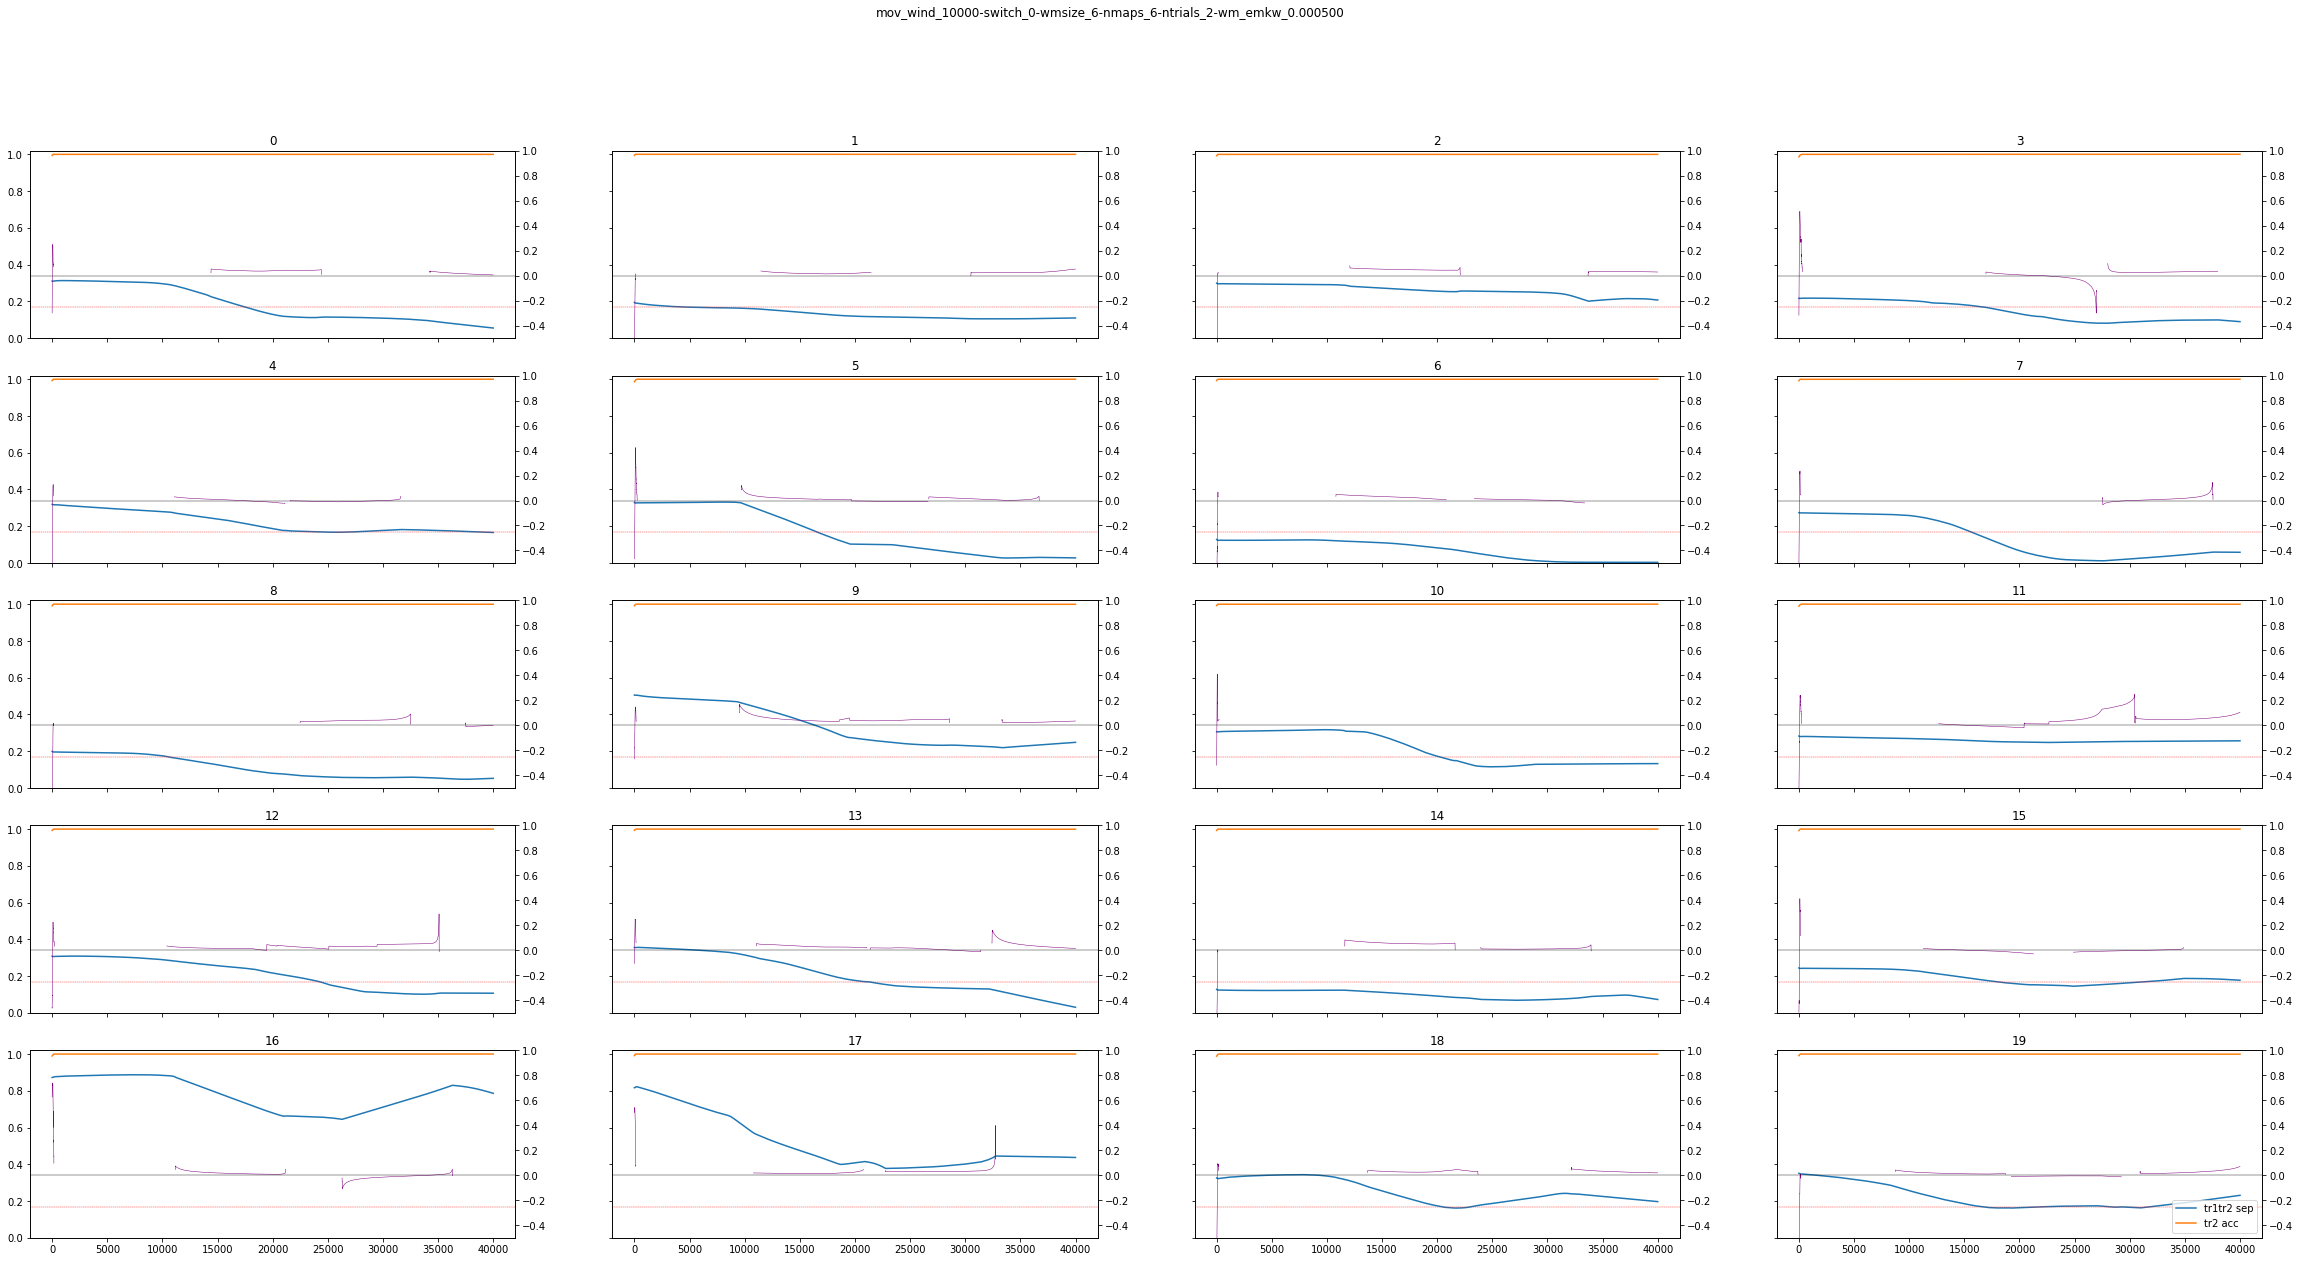

In [83]:
''' edit this to load precomputed mov corr data'''
# plt params
# nnets_plt = 20
# f = 2
# mawind = 10000
# for mawind in [500,10000]:

#   for wmsize,nmaps,switch,ntrials in itertools.product(wmsizeL,nmapsL,switchL,ntrialsL):

#     plt.close('all')
#     fig,axarr = plt.subplots(5,4,figsize=(20*f,10*f),sharex=True,sharey=True);axarr=axarr.reshape(-1)
#     title = "mov_wind_%i-switch_%i-wmsize_%i-nmaps_%i-ntrials_%i-wm_emkw_0.000500"%(
#                 mawind,switch,wmsize,nmaps,ntrials,)
#     plt.suptitle(title)

#     for seed in range(nnets_plt):
#       ax = axarr[seed]
#       # load states and trsc
#       states_subj = load_states_subj(wmsize,nmaps,switch,ntrials,seed)
#       trsc_subj = load_trsc_subj(wmsize,nmaps,switch,ntrials,seed)
#       if type(trsc_subj)==None: continue
#       # compute sep and trac
#       sep_subj = compute_separation(states_subj)
#       sep_subj /= sep_subj.max()
#       trac_subj = trsc_subj[:,1,nmaps:].mean((-1))

#       # plot trac,sep
#       ax.plot(mov_avg(sep_subj,mawind),label='tr1tr2 sep')
#       ax.plot(mov_avg(trac_subj,mawind),label='tr2 acc')
#       # plotmoving correlation sep,trac
#       rho_subj = mov_cor(trac_subj,sep_subj,wind=mawind)
#       ax2 = ax.twinx()
#       ax2.plot(rho_subj,label='movcorr',c='purple',lw=.5)
#       ax2.set_ylim(-.5,1)
#       ax2.axhline(0,c='k',lw=.4)
#       # plot extra
#       ax.set_title(seed)
#       ax.set_ylim(0,1.02)
#       ax.axhline(1/nmaps,c='r',ls='--',lw=.4)
#     ax.legend(loc=4)
#     plt.savefig('figures/amtask-barcode_split/'+title+'.png')

# train and eval

In [131]:
from help_amtask import run_net

In [132]:
# loop params
wmsize = 4
nmaps = 6
switch = 1
ntrials = 2
seed = 1

# net params
emsetting = 1
instdim = 10
stimdim = 12
emk_weights = [1,.0005]

# init
net = NetBarCode(
        wmsize=wmsize,
        emsetting=emsetting,
        seed=seed,
        instdim=instdim,
        stimdim=stimdim,
        init_emkw=emk_weights,
        debug=False
)
task = TaskArbitraryMaps(
          nmaps=nmaps,
          switchmaps=switch,
          ntokens_surplus=0,
          seed=seed,
          stimdim=stimdim
)

In [81]:
# train params
neps_tr = 1000
trlen_tr = 10
ntrials_tr = 2
trsc = run_net(net,task,neps_tr,ntrials_tr,trlen_tr,training=True,verb=True,return_states=False)

0.0 0.0
0.2 0.5625
0.4 0.875
0.6 0.9375
0.8 0.96875


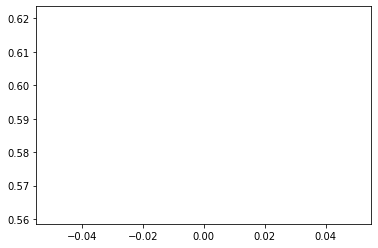

In [84]:
plt.plot(trsc[:,1,nmaps:].mean((-1,-2)))